In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from tensorflow import keras
from keras import models,layers
import pandas as pd
import matplotlib.pyplot as plt

2024-01-18 16:32:34.648492: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-18 16:32:34.848279: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-18 16:32:34.848381: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-18 16:32:34.885736: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-18 16:32:34.961703: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-18 16:32:34.963105: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
#Pas comme ça mais intéressant quand même
#def encodage(dataframe):
#    mapping={} #dictionnaire qui va contenir les chaînes de caractères et l'encodage correspondant
#    for column in dataframe.columns: #column est l'étiquette de la colonne (columns renvoie un tableau d'étiquettes de colonnes)

        #Déterminer les différentes modalités non numériques à encoder
#        if pd.api.types.is_categorical_dtype(dataframe[column]):
#            liste_modalites=dataframe[column].unique() #unique() renvoie un tableau numpy contenant les différents modalités
#            for i,modalite in enumerate(liste_modalites): #enumerate renvoie un objet de type enumerable qui contient des tuples (indice,valeur)
#                mapping[modalite]=i

#            dataframe[column]=dataframe[column].replace(mapping) #Encoder les modalités non numériques
    

In [3]:
def encodage(df):
    df_encoded = df.copy()
    s = (df.dtypes == 'object')
    object_cols = list(s[s].index)
    ordinal_encoder = OrdinalEncoder()
    df_encoded[object_cols]=ordinal_encoder.fit_transform(df[object_cols])    #On peut passer à des dataframes des listes de colonnes :)
    return df_encoded

def imputation(df):
    my_imputer = SimpleImputer()
    df_imputed = pd.DataFrame(my_imputer.fit_transform(df), columns=df.columns) #Ici, on utilise pd.DataFrame(...,columns=df.columns) car l'imputateur renvoie un tableau numpy (sans les titres des colonnes) et pas un dataFrame
    return df_imputed  

def normalize(data):
    data_normalized = data.copy()
    
    for column in data.columns:
        moyenne = data[column].mean()
        ecart_type = data[column].std()
        data_normalized[column] = (data[column] - moyenne) / ecart_type
    
    return data_normalized



In [4]:
pd.set_option('display.max_columns',None)
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
X,y_true=train.drop(['SalePrice','Id','Utilities'], axis=1),train['SalePrice']
X_train,X_test=train_test_split(X,test_size=0.2,random_state=2)
y_true_train,y_true_test=train_test_split(y_true,test_size=0.2,random_state=2)
X_pred=test.drop(['Id','Utilities'],axis=1) #On enlève Utilities car les valeurs de cette variable sont les mêmes pour toutes les données

#Encodage des modalités non numériques
X=encodage(X)
X_train=encodage(X_train)
X_pred=encodage(X_pred)
X_test=encodage(X_test)

#normalisations
X_train=normalize(X_train)
X_test=normalize(X_test)
X_pred=normalize(X_pred)
X=normalize(X)

#Imputations des NaN
X_train=imputation(X_train)
X_pred=imputation(X_pred)
X_test=imputation(X_test)
X=imputation(X)

In [5]:
random_forest=RandomForestRegressor(n_estimators=10,random_state=10)
random_forest.fit(X_train,y_true_train)


RandomForestRegressor(n_estimators=10, random_state=10)

MAE test 19211.846232876713
MAE training 7542.38595890411
R2 test 0.8803584648342484
R2 train 0.9749322943091678


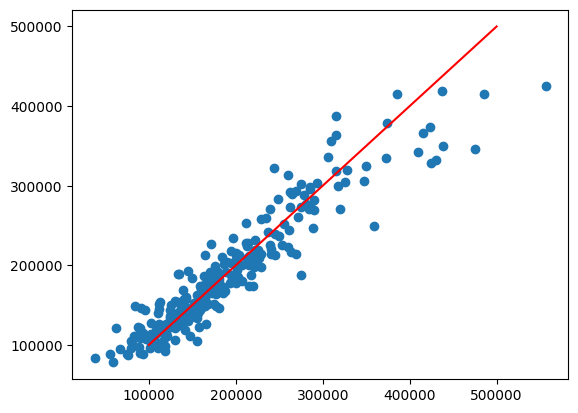

In [6]:
y_test=random_forest.predict(X_test)
y_train=random_forest.predict(X_train)
print("MAE test",mae(y_true_test,y_test))
print("MAE training",mae(y_true_train,y_train))
print("R2 test",r2_score(y_true_test,y_test))
print("R2 train",r2_score(y_true_train,y_train))
plt.plot([100000,200000,300000,400000,500000],[100000,200000,300000,400000,500000],color='r')
plt.scatter(y_true_test,y_test)
plt.show()

Nous obtenons des performances satisfaisantes pour ce premier modèle avec ces hyperparamètres. On a un R2 calculé sur l'échantillon d'apprentissage de 0.97 et un R2 sur l'échantillon de test de 0.87, ils sont les uns des autres, signes d'une bonne capacité du modèle à se généraliser. Le graphe nous montre qu'il n'y a pas de tendances à la sur-estimation ou la sous-estimation. Vérifions si on ne peut pas améliorer les MAE et R2 

In [7]:
#On effectue les prédictions:
y_pred=random_forest.predict(X_pred)
print(y_pred)

[126315. 156400. 181250. ... 153940. 122125. 250930.]


On teste maintenant le modèle de régression linéaire

MAE train: 18143.285402814385
MAE test: 4845774371296607.0
R2 test -4.987294948607467e+21
R2 train 0.8615525388249368


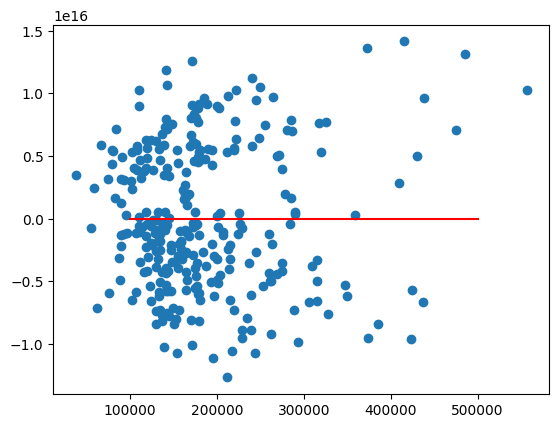

In [8]:
reg_lin=LinearRegression()
reg_lin.fit(X_train,y_true_train)

y_train_mlg=reg_lin.predict(X_train)
y_test_mlg=reg_lin.predict(X_test)
print("MAE train:",mae(y_true_train,y_train_mlg))
print("MAE test:",mae(y_true_test,y_test_mlg))
print("R2 test",r2_score(y_true_test,y_test_mlg))
print("R2 train",r2_score(y_true_train,y_train_mlg))

plt.plot([100000,200000,300000,400000,500000],[100000,200000,300000,400000,500000],color='r')
plt.scatter(y_true_test,y_test_mlg)
plt.show()

La régression linéaire n'est pas adaptée ici

Testons à présent avec des réseaux de neurones

In [9]:
def reseau_neur(nb_neurones_1=64,nb_neurones_2=128):
    model=models.Sequential()

    # Première couche cachée avec nb_neur1 neurones et une fonction d'activation ReLU
    model.add(layers.Dense(nb_neurones_1, activation='relu', input_shape=(X_train.shape[1],)))

    # Deuxième couche cachée avec nb_neur2 et une fonction d'activation ReLU
    model.add(layers.Dense(nb_neurones_2, activation='relu'))

    # Couche de sortie avec 1 neurone 
    model.add(layers.Dense(1))

    model.compile(optimizer='adam',loss='mean_squared_error',metrics=['mse'])

    return model

In [10]:
model=reseau_neur()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                5056      
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 13505 (52.75 KB)
Trainable params: 13505 (52.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
model.fit(X_train,y_true_train,epochs=200, batch_size=32)
y_train_neur=model.predict(X_train)
y_test_neur=model.predict(X_test)

print(y_test_neur)

Epoch 1/200
37/37 [==============================] - 1s 3ms/step - loss: 38615048192.0000 - mse: 38615048192.0000
Epoch 2/200
37/37 [==============================] - 0s 3ms/step - loss: 38605590528.0000 - mse: 38605590528.0000
Epoch 3/200
37/37 [==============================] - 0s 3ms/step - loss: 38569455616.0000 - mse: 38569455616.0000
Epoch 4/200
37/37 [==============================] - 0s 2ms/step - loss: 38470320128.0000 - mse: 38470320128.0000
Epoch 5/200
37/37 [==============================] - 0s 2ms/step - loss: 38261841920.0000 - mse: 38261841920.0000
Epoch 6/200
37/37 [==============================] - 0s 2ms/step - loss: 37895114752.0000 - mse: 37895114752.0000
Epoch 7/200
37/37 [==============================] - 0s 2ms/step - loss: 37327581184.0000 - mse: 37327581184.0000
Epoch 8/200
37/37 [==============================] - 0s 2ms/step - loss: 36545667072.0000 - mse: 36545667072.0000
Epoch 9/200
37/37 [==============================] - 0s 2ms/step - loss: 35501989888.000

In [12]:
print("mae_train",mae(y_true_train,y_train_neur))
print("mae_test",mae(y_true_test,y_test_neur))

mae_train 21554.55890812286
mae_test 27023.85989672517


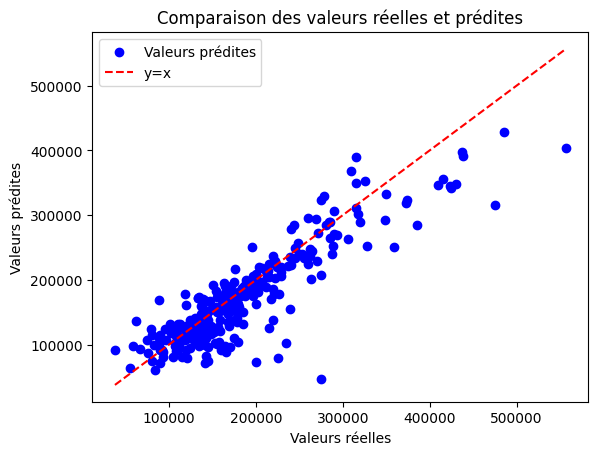

In [13]:
# Tracer le graphique
plt.scatter(y_true_test, y_test_neur, color='blue', label='Valeurs prédites')

# Tracer la droite y=x pour comparer
plt.plot([min(y_true_test), max(y_true_test)], [min(y_true_test), max(y_true_test)], linestyle='--', color='red', label='y=x')
# Ajouter des labels et une légende
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')
plt.title('Comparaison des valeurs réelles et prédites')
plt.legend()

# Afficher le graphique
plt.show()

Performances satisfaisantes mais moins que les performances du random-tree forest. On va chercher à optimiser ces paramètres:

In [14]:
from scikeras.wrappers import KerasRegressor
list_neurones_couche1,list_neurones_couche2=[32,64,128,256,512],[32,64,128,256,512]
param_grid = {
    'nb_neurones_1': list_neurones_couche1,
    'nb_neurones_2': list_neurones_couche2
}
modelForGridSearch = KerasRegressor(nb_neurones_1=32,nb_neurones_2=32,build_fn=reseau_neur, verbose=0) #pour éviter des erruers de non reconnaissance des nb de neurones je les ai initialisés
grid_search=GridSearchCV(modelForGridSearch,param_grid,cv=5,scoring='neg_mean_squared_error',n_jobs=-1,verbose=0)
grid_search.fit(X,y_true)
nb_neur_opti=grid_search.best_params_
print(nb_neur_opti)


2024-01-18 16:33:00.184026: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-18 16:33:00.202460: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-18 16:33:00.240456: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-18 16:33:00.273106: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-18 16:33:00.273247: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-18 16:33:00.275302: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to regis

{'nb_neurones_1': 512, 'nb_neurones_2': 512}


Cherchons le paramètre optimal pour le random forest 

In [15]:
list_n_estimators=range(10,100)
param_grid_2=dict(n_estimators=list_n_estimators)
grid_search=GridSearchCV(random_forest,param_grid=param_grid_2,cv=5,scoring='neg_mean_squared_error',n_jobs=-1)
grid_search.fit(X,y_true)
n_estimators_opti=grid_search.best_params_
print(n_estimators_opti)


{'n_estimators': 55}


On compare les performances des deux modèles avec les paramètres optimaux sur les différences ensembles de train,test et validation:

RESEAU DE NEURONES:

Train set:

In [37]:
model=reseau_neur(nb_neur_opti['nb_neurones_1'],nb_neur_opti['nb_neurones_2'])
model.fit(X_train,y_true_train,epochs=200, batch_size=32)
y_train_opti=model.predict(X_train)
print("mae_train_opti",mae(y_true_train,y_train_opti))

Epoch 1/200
37/37 [==============================] - 1s 5ms/step - loss: 38594199552.0000 - mse: 38594199552.0000
Epoch 2/200
37/37 [==============================] - 0s 5ms/step - loss: 38339526656.0000 - mse: 38339526656.0000
Epoch 3/200
37/37 [==============================] - 0s 5ms/step - loss: 37153751040.0000 - mse: 37153751040.0000
Epoch 4/200
37/37 [==============================] - 0s 5ms/step - loss: 34001627136.0000 - mse: 34001627136.0000
Epoch 5/200
37/37 [==============================] - 0s 5ms/step - loss: 28311490560.0000 - mse: 28311490560.0000
Epoch 6/200
37/37 [==============================] - 0s 5ms/step - loss: 21093306368.0000 - mse: 21093306368.0000
Epoch 7/200
37/37 [==============================] - 0s 5ms/step - loss: 14444553216.0000 - mse: 14444553216.0000
Epoch 8/200
37/37 [==============================] - 0s 5ms/step - loss: 10230407168.0000 - mse: 10230407168.0000
Epoch 9/200
37/37 [==============================] - 0s 5ms/step - loss: 8268081664.0000

Test set:

In [38]:
y_test_opti=model.predict(X_test)
print("mae_test_opti",mae(y_true_test,y_test_opti))

10/10 [==============================] - 0s 2ms/step
mae_test_opti 21673.08425192637


Validation set:

In [39]:
model.fit(X,y_true,epochs=200, batch_size=32) #on réentraine sur toutes les données pour profiter de tout le dataset
y_valid_opti=model.predict(X)
print("mae_validation",mae(y_true,y_valid_opti))

Epoch 1/200
46/46 [==============================] - 0s 5ms/step - loss: 514521280.0000 - mse: 514521280.0000
Epoch 2/200
46/46 [==============================] - 0s 5ms/step - loss: 494882592.0000 - mse: 494882592.0000
Epoch 3/200
46/46 [==============================] - 0s 5ms/step - loss: 491992576.0000 - mse: 491992576.0000
Epoch 4/200
46/46 [==============================] - 0s 5ms/step - loss: 483506976.0000 - mse: 483506976.0000
Epoch 5/200
46/46 [==============================] - 0s 5ms/step - loss: 477608384.0000 - mse: 477608384.0000
Epoch 6/200
46/46 [==============================] - 0s 5ms/step - loss: 471745504.0000 - mse: 471745504.0000
Epoch 7/200
46/46 [==============================] - 0s 5ms/step - loss: 465029056.0000 - mse: 465029056.0000
Epoch 8/200
46/46 [==============================] - 0s 6ms/step - loss: 461093536.0000 - mse: 461093536.0000
Epoch 9/200
46/46 [==============================] - 0s 6ms/step - loss: 457171872.0000 - mse: 457171872.0000
Epoch 10/2

RANDOM FOREST REGRESSOR:

Train set:

In [40]:
random_forest=RandomForestRegressor(n_estimators=n_estimators_opti['n_estimators'],random_state=10)
random_forest.fit(X_train,y_true_train)
y_train_opti2=model.predict(X_train)
print("mae_train_opti",mae(y_true_train,y_train_opti2))

37/37 [==============================] - 0s 2ms/step
mae_train_opti 8023.586576278895


Test set:

In [41]:
y_test_opti2=random_forest.predict(X_test)
print("mae_test_opti",mae(y_true_test,y_test_opti2))

mae_test_opti 18780.67789539228


Validation set:

In [42]:
model.fit(X,y_true) #on réentraine sur toutes les données pour profiter de tout le dataset
y_valid_opti2=model.predict(X)
print("mae_validation_opti",mae(y_true,y_valid_opti2))

46/46 [==============================] - 0s 2ms/step
mae_validation_opti 7711.089536065924


Le random forest reste supérieur en termes de précision, on remarque toutefois que l'écart entre ces eux modèles sur l'ensemble des données est petit (de l'ordre de 1,5%).
Le réseau de neurones se généralie toutefois mieux que le randomforest (voir l'écart des mae).